In [48]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [49]:
df_avg = pd.read_excel('Output/For_analysis/prison_agg_data_2014_2024.xlsx')

In [50]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# If df_avg is your new aggregated DataFrame
# Optional log transform
df_avg['log_avg_population'] = np.log(df_avg['Avg_Population'].clip(lower=1))

# Standardize predictors
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_avg[['occ_scaled', 'logpop_scaled']] = scaler.fit_transform(
    df_avg[['Avg_Occupancy_Percentage', 'log_avg_population']]
)

# Fit a simple OLS model first
model = smf.ols('Avg_Deaths ~ occ_scaled + logpop_scaled', data=df_avg).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:             Avg_Deaths   R-squared:                       0.403
Model:                            OLS   Adj. R-squared:                  0.393
Method:                 Least Squares   F-statistic:                     40.45
Date:                 Пн, 14 апр 2025   Prob (F-statistic):           3.74e-14
Time:                        04:00:49   Log-Likelihood:                 65.382
No. Observations:                 123   AIC:                            -124.8
Df Residuals:                     120   BIC:                            -116.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.2113      0.013     16.279

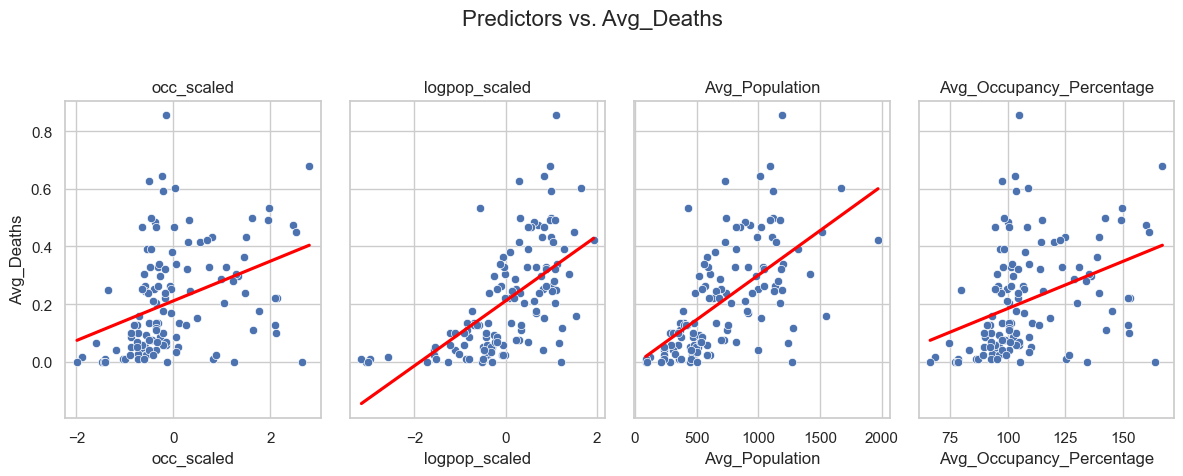

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

# List your predictors
predictors = ['occ_scaled', 'logpop_scaled', 'Avg_Population', 'Avg_Occupancy_Percentage']
outcome = 'Avg_Deaths'

# Set up subplots
fig, axes = plt.subplots(nrows=1, ncols=len(predictors), figsize=(12, 5), sharey=True)
fig.suptitle('Predictors vs. Avg_Deaths', fontsize=16)

# Plot each predictor
for i, predictor in enumerate(predictors):
    ax = axes[i]
    sns.scatterplot(data=df_avg, x=predictor, y=outcome, ax=ax)
    sns.regplot(data=df_avg, x=predictor, y=outcome, ax=ax, scatter=False, color='red', ci=None)
    ax.set_title(predictor)
    ax.set_xlabel(predictor)
    ax.set_ylabel(outcome if i == 0 else '')  # Only label y-axis once

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit title
plt.show()


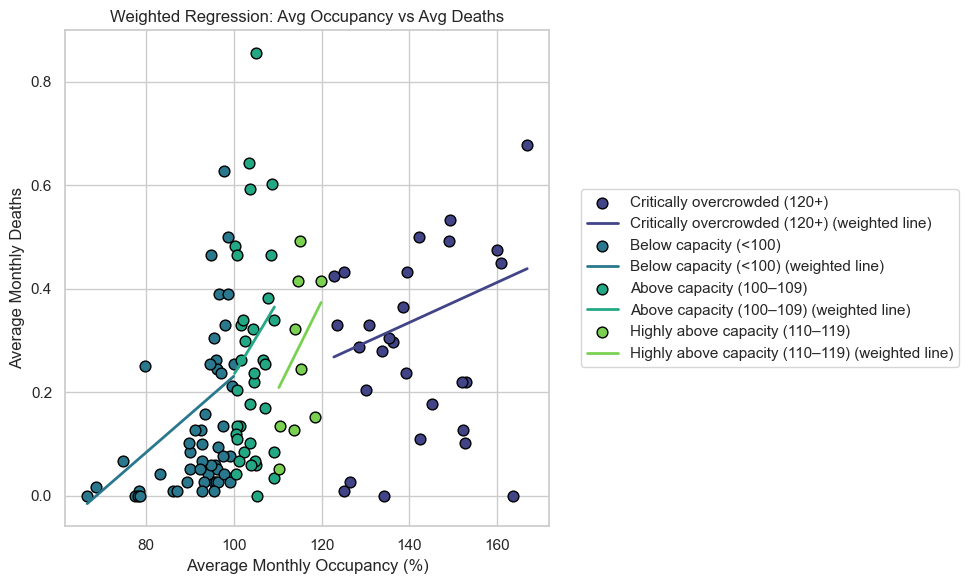

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import numpy as np

# 1. Categorize occupancy level
def categorize_occupancy(val):
    if val < 100:
        return "Below capacity (<100)"
    elif val < 110:
        return "Above capacity (100–109)"
    elif val < 120:
        return "Highly above capacity (110–119)"
    else:
        return "Critically overcrowded (120+)"

df_avg['Occupancy_Level'] = df_avg['Avg_Occupancy_Percentage'].apply(categorize_occupancy)

# 2. Base scatterplot with colored groups
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

palette = sns.color_palette("viridis", df_avg['Occupancy_Level'].nunique())
levels = df_avg['Occupancy_Level'].unique()
color_map = dict(zip(levels, palette))

for level in levels:
    subset = df_avg[df_avg['Occupancy_Level'] == level]
    plt.scatter(
        subset['Avg_Occupancy_Percentage'], 
        subset['Avg_Deaths'], 
        label=level,
        s=60, edgecolor='black',
        color=color_map[level]
    )
    
    # 3. Fit weighted regression
    X = sm.add_constant(subset['Avg_Occupancy_Percentage'])
    y = subset['Avg_Deaths']
    wls_model = sm.WLS(y, X, weights=subset['Avg_Population'])
    results = wls_model.fit()
    
    # 4. Plot weighted line
    x_vals = np.linspace(subset['Avg_Occupancy_Percentage'].min(), 
                         subset['Avg_Occupancy_Percentage'].max(), 100)
    y_vals = results.predict(sm.add_constant(x_vals))
    plt.plot(x_vals, y_vals, color=color_map[level], label=f"{level} (weighted line)", linewidth=2)

# 5. Final styling
plt.title("Weighted Regression: Avg Occupancy vs Avg Deaths")
plt.xlabel("Average Monthly Occupancy (%)")
plt.ylabel("Average Monthly Deaths")
plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left')
plt.tight_layout()
plt.show()


C:\Users\Denis\AppData\Local\Temp\ipykernel_7500\2776172516.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


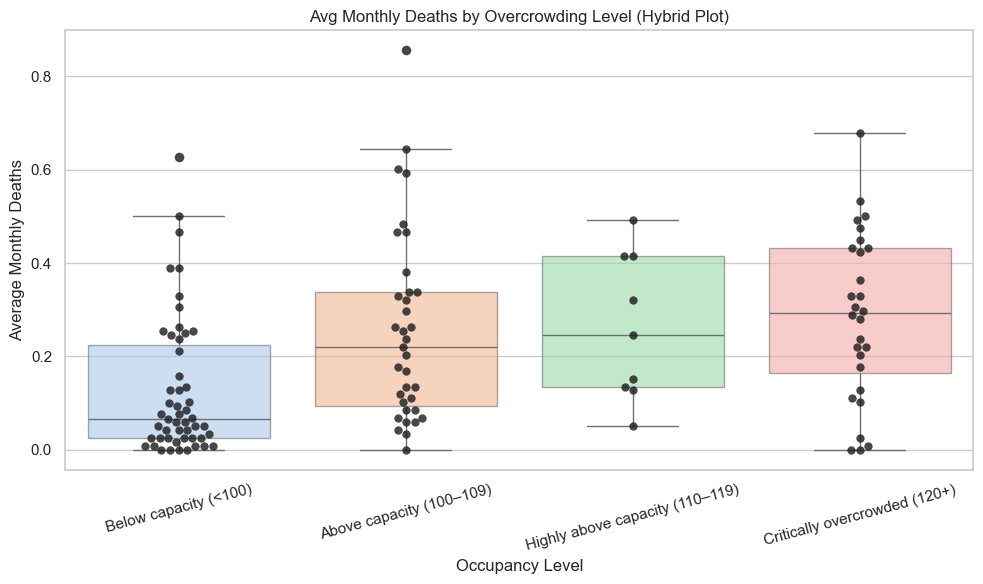

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Ensure occupancy level is defined and ordered
def categorize_occupancy(val):
    if val < 100:
        return "Below capacity (<100)"
    elif val < 110:
        return "Above capacity (100–109)"
    elif val < 120:
        return "Highly above capacity (110–119)"
    else:
        return "Critically overcrowded (120+)"

df_avg['Occupancy_Level'] = df_avg['Avg_Occupancy_Percentage'].apply(categorize_occupancy)
ordered_levels = [
    "Below capacity (<100)",
    "Above capacity (100–109)",
    "Highly above capacity (110–119)",
    "Critically overcrowded (120+)"
]
df_avg['Occupancy_Level'] = pd.Categorical(df_avg['Occupancy_Level'], categories=ordered_levels, ordered=True)

# Plot
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

# First the boxplot
sns.boxplot(
    data=df_avg,
    x='Occupancy_Level',
    y='Avg_Deaths',
    palette='pastel',
    boxprops=dict(alpha=0.6)  # slightly transparent
)

# Then the swarmplot on top
sns.swarmplot(
    data=df_avg,
    x='Occupancy_Level',
    y='Avg_Deaths',
    color='k',
    alpha=0.8,
    size=6,
    edgecolor='white'
)

# Labels and layout
plt.title("Avg Monthly Deaths by Overcrowding Level (Hybrid Plot)")
plt.xlabel("Occupancy Level")
plt.ylabel("Average Monthly Deaths")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


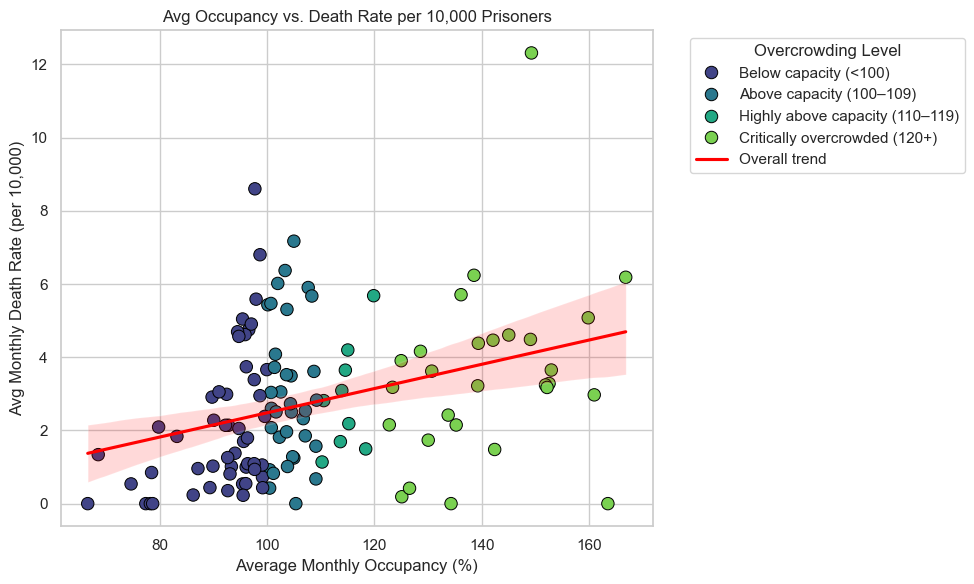

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Calculate death rate per 10,000 inmates
df_avg['Avg_Death_Rate'] = df_avg['Avg_Deaths'] * 10000 / df_avg['Avg_Population']

# Optional: reuse categorized overcrowding levels
def categorize_occupancy(val):
    if val < 100:
        return "Below capacity (<100)"
    elif val < 110:
        return "Above capacity (100–109)"
    elif val < 120:
        return "Highly above capacity (110–119)"
    else:
        return "Critically overcrowded (120+)"

df_avg['Occupancy_Level'] = df_avg['Avg_Occupancy_Percentage'].apply(categorize_occupancy)
ordered_levels = [
    "Below capacity (<100)",
    "Above capacity (100–109)",
    "Highly above capacity (110–119)",
    "Critically overcrowded (120+)"
]
df_avg['Occupancy_Level'] = pd.Categorical(df_avg['Occupancy_Level'], categories=ordered_levels, ordered=True)

# Plot
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

sns.scatterplot(
    data=df_avg,
    x='Avg_Occupancy_Percentage',
    y='Avg_Death_Rate',
    hue='Occupancy_Level',
    palette='viridis',
    s=80,
    edgecolor='black'
)

# Add single linear regression line across all data
sns.regplot(
    data=df_avg,
    x='Avg_Occupancy_Percentage',
    y='Avg_Death_Rate',
    scatter=False,
    color='red',
    label='Overall trend'
)

plt.title("Avg Occupancy vs. Death Rate per 10,000 Prisoners")
plt.xlabel("Average Monthly Occupancy (%)")
plt.ylabel("Avg Monthly Death Rate (per 10,000)")
plt.legend(title="Overcrowding Level", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


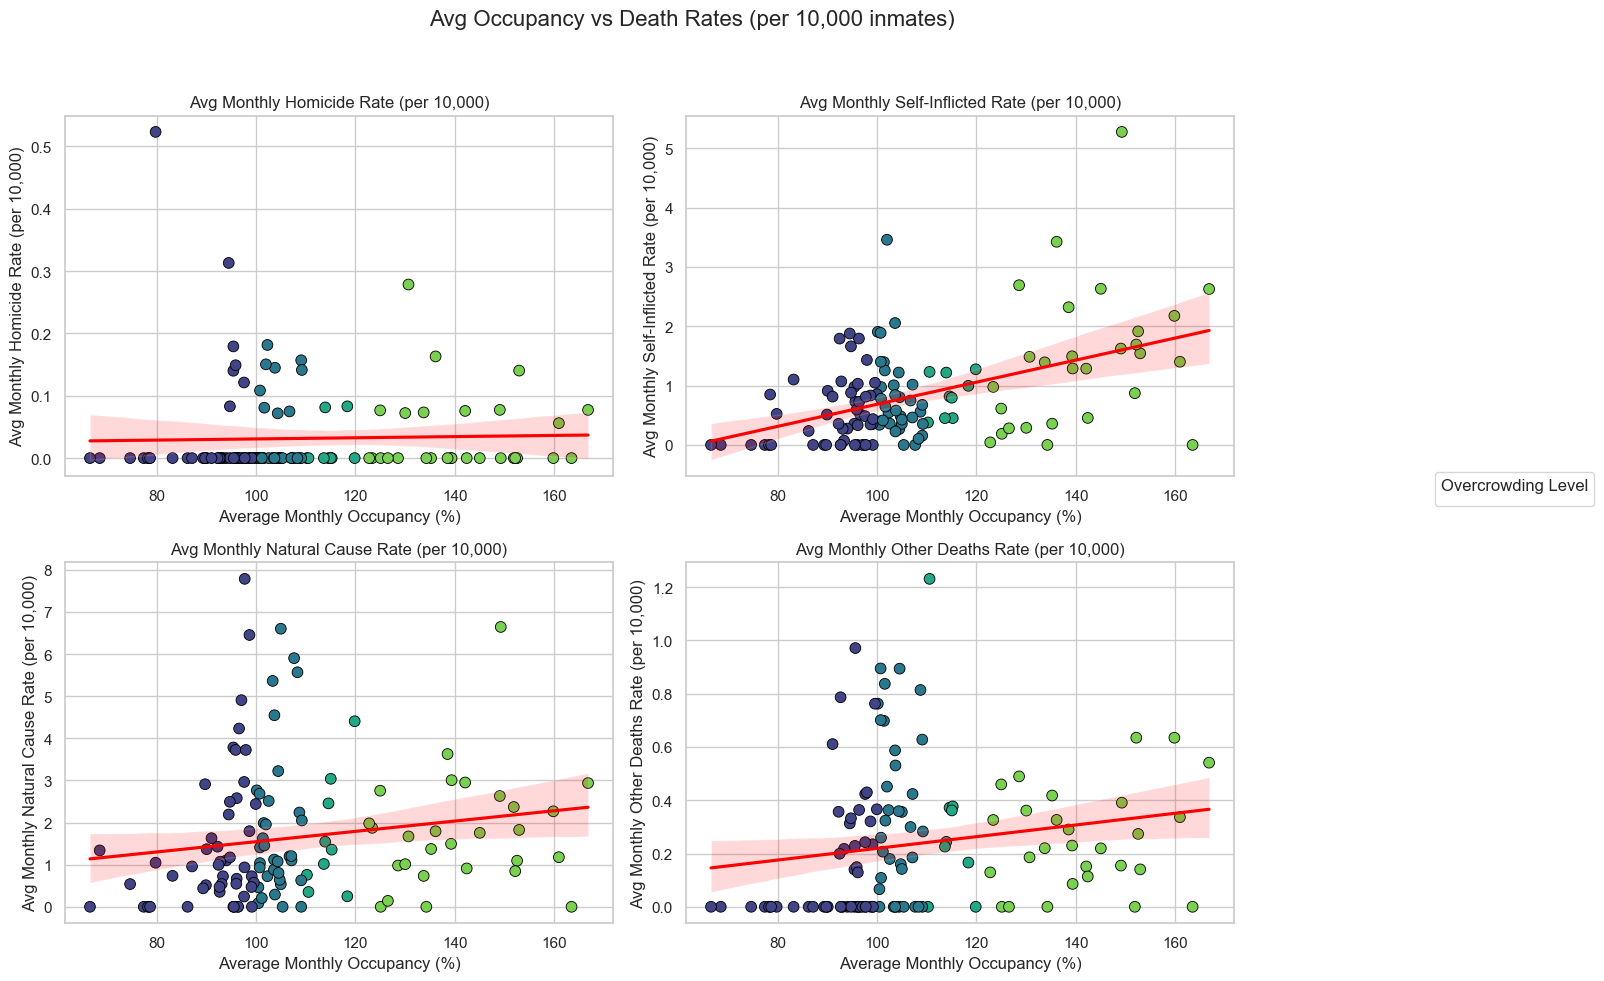

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

# First, calculate the per-10k rates for each death type
df_avg['Homicide_Rate'] = df_avg['Avg_Homicide'] * 10000 / df_avg['Avg_Population']
df_avg['SelfInflicted_Rate'] = df_avg['Avg_SelfInflicted'] * 10000 / df_avg['Avg_Population']
df_avg['Natural_Rate'] = df_avg['Avg_Natural'] * 10000 / df_avg['Avg_Population']
df_avg['Other_Rate'] = df_avg['Avg_Other'] * 10000 / df_avg['Avg_Population']

# Set up plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

death_types = [
    ("Homicide_Rate", "Avg Monthly Homicide Rate (per 10,000)"),
    ("SelfInflicted_Rate", "Avg Monthly Self-Inflicted Rate (per 10,000)"),
    ("Natural_Rate", "Avg Monthly Natural Cause Rate (per 10,000)"),
    ("Other_Rate", "Avg Monthly Other Deaths Rate (per 10,000)")
]

# Shared color palette
palette = sns.color_palette("viridis", n_colors=4)
occupancy_order = [
    "Below capacity (<100)",
    "Above capacity (100–109)",
    "Highly above capacity (110–119)",
    "Critically overcrowded (120+)"
]

for i, (col, ylabel) in enumerate(death_types):
    ax = axes[i]
    sns.scatterplot(
        data=df_avg,
        x='Avg_Occupancy_Percentage',
        y=col,
        hue='Occupancy_Level',
        hue_order=occupancy_order,
        palette=palette,
        s=60,
        edgecolor='black',
        ax=ax,
        legend=False  # We'll add a single legend later
    )
    sns.regplot(
        data=df_avg,
        x='Avg_Occupancy_Percentage',
        y=col,
        scatter=False,
        color='red',
        ax=ax
    )
    ax.set_title(ylabel)
    ax.set_xlabel("Average Monthly Occupancy (%)")
    ax.set_ylabel(ylabel)

# Add one legend for all
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Overcrowding Level", loc='center right', bbox_to_anchor=(1.15, 0.5))

fig.suptitle("Avg Occupancy vs Death Rates (per 10,000 inmates)", fontsize=16)
plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.show()


In [56]:
df

,Prison_name,Avg_Population,Avg_Occupancy_Percentage,Avg_Deaths,Avg_SelfInflicted,Avg_Natural,Avg_Other,N_Months,A,B,C,D,YOI,Male,Female,Mixed,Female_open,Female_closed,Highest_category_male,Highest_category_female
0,Altcourse,1119.830508,142.106726,0.500000,0.144068,0.330508,0.016949,118,0,1,0,0,1,1,0,0,0,0,B,Other
1,Ashfield,400.305085,97.595082,0.135593,0.000000,0.118644,0.016949,118,0,0,1,0,0,1,0,0,0,0,C,Other
2,Askham Grange,99.694915,78.450258,0.008475,0.008475,0.000000,0.000000,118,0,0,0,0,0,0,1,0,1,0,Other,Open
3,Aylesbury,348.940678,95.607281,0.059322,0.025424,0.000000,0.033898,118,0,0,0,0,1,1,0,0,0,0,YOI,Other
4,Bedford,386.288136,145.049560,0.177966,0.101695,0.067797,0.008475,118,0,1,0,0,0,1,0,0,0,0,B,Other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,Whitemoor,416.186441,91.025129,0.127119,0.033898,0.067797,0.025424,118,1,0,0,0,0,1,0,0,0,0,A,Other
119,Winchester,584.118644,138.565132,0.364407,0.135593,0.211864,0.016949,118,0,1,0,0,0,1,0,0,0,0,B,Other
120,Woodhill,563.483051,101.981508,0.338983,0.194915,0.110169,0.025424,118,1,0,0,0,0,1,0,0,0,0,A,Other
121,Wormwood Scrubs,1180.144068,104.349578,0.322034,0.144068,0.127119,0.042373,118,0,1,0,0,0,1,0,0,0,0,B,Other


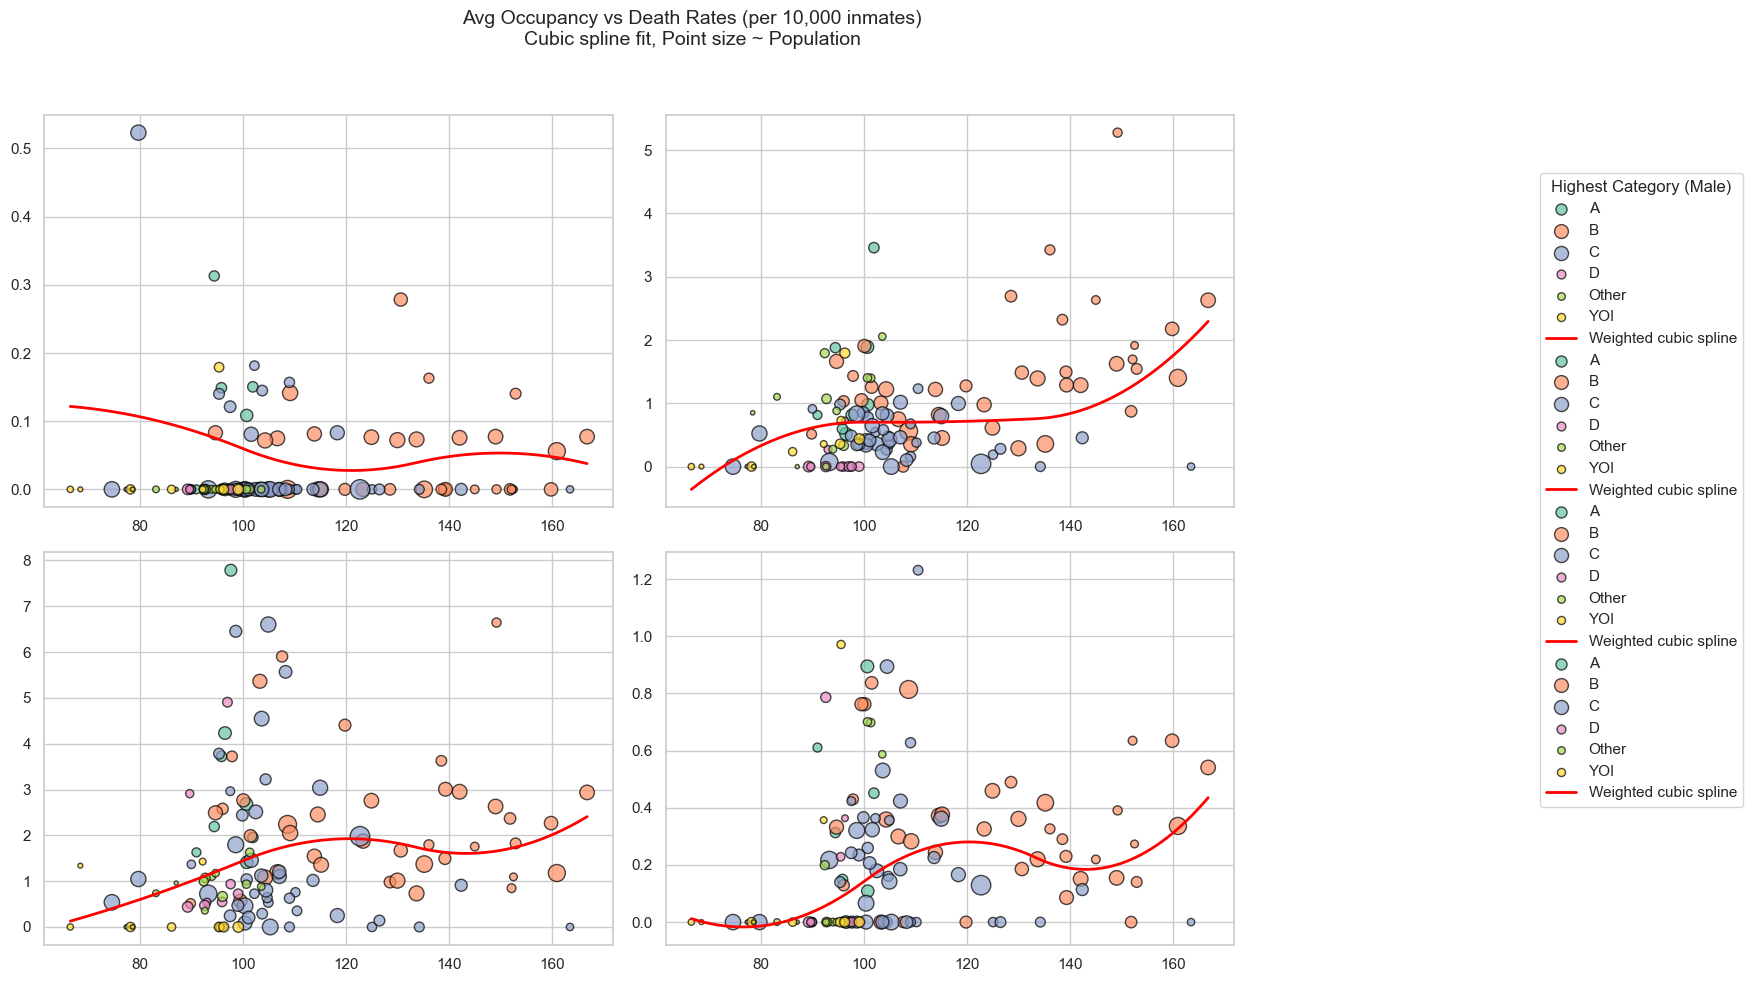

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from patsy import dmatrix
from sklearn.linear_model import LinearRegression

# Calculate rates (if not done)
df_avg['Homicide_Rate'] = df_avg['Avg_Homicide'] * 10000 / df_avg['Avg_Population']
df_avg['SelfInflicted_Rate'] = df_avg['Avg_SelfInflicted'] * 10000 / df_avg['Avg_Population']
df_avg['Natural_Rate'] = df_avg['Avg_Natural'] * 10000 / df_avg['Avg_Population']
df_avg['Other_Rate'] = df_avg['Avg_Other'] * 10000 / df_avg['Avg_Population']

# Set up subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

death_types = [
    ("Homicide_Rate", "Avg Monthly Homicide Rate (per 10,000)"),
    ("SelfInflicted_Rate", "Avg Monthly Self-Inflicted Rate (per 10,000)"),
    ("Natural_Rate", "Avg Monthly Natural Cause Rate (per 10,000)"),
    ("Other_Rate", "Avg Monthly Other Deaths Rate (per 10,000)")
]

# Define category and color mapping
category_order = sorted(df_avg['Highest_category_male'].dropna().unique())
palette = sns.color_palette("Set2", n_colors=len(category_order))
color_map = dict(zip(category_order, palette))

for i, (col, ylabel) in enumerate(death_types):
    ax = axes[i]
    
    # Plot each category separately
    for cat in category_order:
        subset = df_avg[df_avg['Highest_category_male'] == cat]
        ax.scatter(
            subset['Avg_Occupancy_Percentage'],
            subset[col],
            s=subset['Avg_Population'] / 10,  # Adjust size scaling as needed
            color=color_map[cat],
            edgecolor='black',
            label=cat,
            alpha=0.7
        )

    # Fit and plot a cubic spline with weights
    x = df_avg['Avg_Occupancy_Percentage']
    y = df_avg[col]
    weights = df_avg['Avg_Population']

    X_spline = dmatrix("bs(x, df=4, degree=2, include_intercept=False)", {"x": x}, return_type='dataframe')
    model = LinearRegression().fit(X_spline, y, sample_weight=weights)

    x_pred = np.linspace(x.min(), x.max(), 300)
    X_pred_spline = dmatrix("bs(x, df=4, degree=2, include_intercept=False)", {"x": x_pred}, return_type='dataframe')
    y_pred = model.predict(X_pred_spline)

    ax.plot(x_pred, y_pred, color='red', linewidth=2, label="Weighted cubic spline")

# Final layout
fig.legend(title="Highest Category (Male)", bbox_to_anchor=(1.1, 0.5), loc='center left')
fig.suptitle("Avg Occupancy vs Death Rates (per 10,000 inmates)\nCubic spline fit, Point size ~ Population", fontsize=14)
plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.show()
